In [1]:
import pandas as pd
import urllib.request
import zipfile
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'
def extract_zip(src, dst, member_name):
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name),low_memory=False)
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

raw = extract_zip(url, fname, member_name)

In [2]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [3]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.
    This function takes a Pandas DataFrame containing Kaggle
    survey data as input and returns a new DataFrame. The
    modifications include extracting and transforming certain
    columns, renaming columns, and selecting a subset of columns.
    Parameters
    ----------
    df_ : pd.DataFrame
    The input DataFrame containing Kaggle survey data.
    Returns
    -------
    pd.DataFrame
    The new DataFrame with the modified and selected columns.
    """
    return (
        df_.assign(
            age=df_.Q2.str.slice(0,2).astype(int),
            education=df_.Q4.replace({'Master’s degree': 18,
                'Bachelor’s degree': 16,
                'Doctoral degree': 20,
                'Some college/university study without earning a bachelor’s degree': 13,
                'Professional degree': 19,
                'I prefer not to answer': None,
                'No formal education past high school': 12}),
            major=(df_.Q5
                .pipe(topn, n=3)
                .replace({
                    'Computer science (software engineering, etc.)': 'cs',
                    'Engineering (non-computer focused)': 'eng',
                    'Mathematics or statistics': 'stat'})
                ),
            years_exp=(df_.Q8.str.replace('+','', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .astype(float)),
            compensation=(df_.Q9.str.replace('+','', regex=False)
                .str.replace(',','', regex=False)
                .str.replace('500000', '500', regex=False)
                .str.replace('I do not wish to disclose my approximate yearly compensation',
                '0', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .fillna(0)
                .astype(int)
                .mul(1_000)
                ),
            python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
            r=df_.Q16_Part_2.fillna(0).replace('R', 1),
            sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
        )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
        'python,r,sql'.split(',')]
    )


In [4]:
from sklearn import base, pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 

In [5]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self


In [6]:
trans=TweakKagTransformer()

In [7]:
trans.fit_transform(raw)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

,Q1,Q3,age,education,major,years_exp,compensation,python,r,sql
1,Female,United States of America,45,20.0,other,NaN,0,0,0,0
2,Male,Indonesia,30,16.0,eng,5.0,10000,0,0,1
3,Female,United States of America,30,18.0,cs,0.0,0,0,1,0
4,Male,United States of America,35,18.0,other,NaN,0,1,1,1
5,Male,India,22,18.0,stat,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
23855,Male,France,45,20.0,cs,5.0,250000,1,1,1
23856,Female,Turkey,25,18.0,eng,NaN,0,0,0,0
23857,Male,Turkey,22,18.0,cs,0.0,10000,0,0,0
23858,Male,United Kingdom of Great Britain and Northern I...,25,NaN,other,NaN,0,0,0,0


In [8]:
def get_rawX_y(df, y_col):
    raw = (df
    .query('Q3.isin(["United States of America", "China", "India"]) '
    'and Q6.isin(["Data Scientist", "Software Engineer"])')
    )
    return raw.drop(columns=[y_col]), raw[y_col]

In [9]:
%pip install feature_engine

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from feature_engine import encoding, imputation

In [11]:
## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                                                variables=['education', 'years_exp']))]
)

In [12]:
from sklearn import model_selection
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [13]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [14]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [15]:
X_test = kag_pl.transform(kag_X_test)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2068\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [16]:
from sklearn import tree

In [17]:
import matplotlib.pyplot as plt

In [39]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, kag_y_train)
rf.score(X_test, kag_y_test)

0.7237569060773481

In [40]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
print(rf.estimators_[0])

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)


[Text(0.5, 0.875, 'Q3_United States of America <= 0.5\ngini = 0.496\nsamples = 1354\nvalue = [1146.0, 964.0]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'r <= 0.5\ngini = 0.496\nsamples = 681\nvalue = [496, 588]\nclass = Software Engineer'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'education <= 17.0\ngini = 0.469\nsamples = 530\nvalue = [317, 528]\nclass = Software Engineer'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'education <= 17.0\ngini = 0.376\nsamples = 151\nvalue = [179, 60]\nclass = Data Scientist'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'education <= 17.0\ngini = 0.464\nsamples = 673\nvalue = [650, 376]\nclass = Data Scientist'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'major_cs <= 0.5\ngini = 0.485\nsamples = 176\nvalue = [109, 154]\nclass = Software Engineer'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),

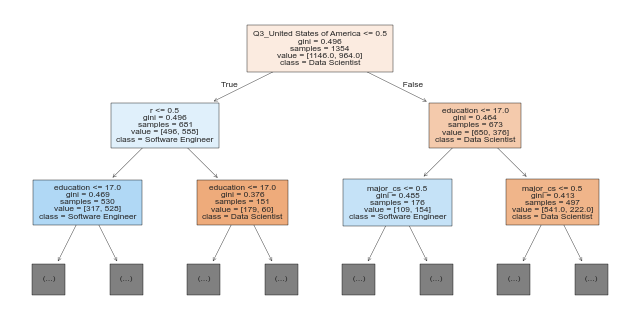

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(rf.estimators_[0], feature_names=features,
filled=True, class_names=rf.classes_, ax=ax,
max_depth=2, fontsize=6)

In [45]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
y_train=le.fit_transform(kag_y_train)
y_test=le.transform(kag_y_test)

In [46]:
le.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [48]:
import xgboost as xgb
rf_xg = xgb.XGBRFClassifier(random_state=42)
rf_xg.fit(X_train, y_train)
rf_xg.score(X_test, y_test)

0.7480662983425415

In [49]:
rf_xg.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Axes: >

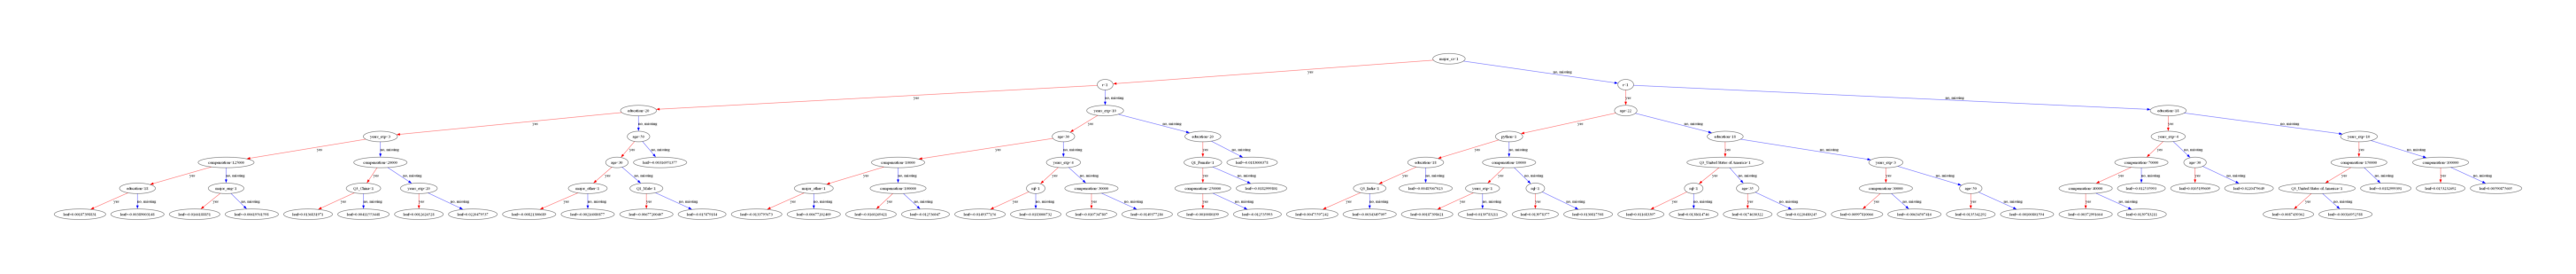

In [50]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
xgb.plot_tree(rf_xg, num_trees=0, ax=ax, size='1,1')

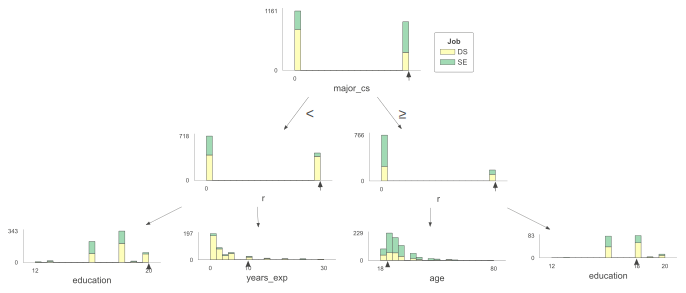

In [52]:
import dtreeviz
viz = dtreeviz.model(rf_xg, X_train=X_train,
y_train=y_train,
target_name='Job', feature_names=list(X_train.columns),
class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])

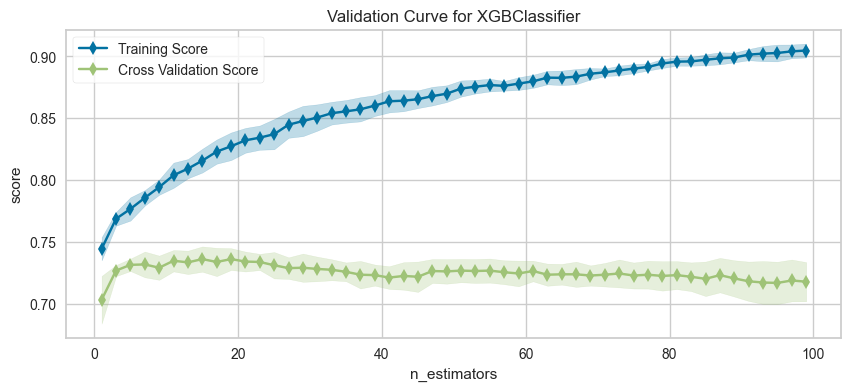

In [55]:
import numpy as np
from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))
viz = validation_curve(xgb.XGBClassifier(random_state=42),
X=pd.concat([X_train, X_test], axis='index'),
y=np.concatenate([y_train, y_test]),
param_name='n_estimators', param_range=range(1, 100, 2),
scoring='accuracy', cv=3,
ax=ax)

In [56]:
rf_xg29 = xgb.XGBRFClassifier(random_state=42, n_estimators=29)

In [57]:
rf_xg29.fit(X_train, y_train)
rf_xg29.score(X_test, y_test)

0.7480662983425415